# Assignment 2 - Transforms, Homogeneous Notation and Projection

In [659]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [660]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [661]:
# Set up python path 
import sys
import os
import cv2
import numpy as np 
import torch 
import math 
from math import sin, cos
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [662]:
# Projection operator
def pi(x): 
    dim = x.shape[0]
    x /= x[dim-1]
    return x[0:-1]

# Unprojection operator
def pi_inv(x): 
    dim = x.shape[0]
    x = np.concatenate((x, np.array([1,])), dtype=np.float32)
    return x 

# Returns a floating point numpy array 
def data(x):
    return np.array(x, dtype=np.float32)

# Multiplies a list of matrices together
def matmul(*x): 
    if len(x) == 1: return x 
    if len(x) == 2: return np.matmul(*x)
    result = np.matmul(x[0], x[1])
    for i in range(2, len(x)): 
        result = np.matmul(result, x[i])
    return result

In [663]:
# Define data 
cube_vertices = [
    data([0, 0, 0, 1]),
    data([1, 0, 0, 1]),
    data([1, 0, 1, 1]),
    data([0, 0, 1, 1]),
    data([0, 1, 0, 1]),
    data([1, 1, 0, 1]),
    data([1, 1, 1, 1]),
    data([0, 1, 1, 1])
]

cube_lines = [
    (0, 1), 
    (1, 2),
    (2, 3), 
    (3, 0), 
    (4, 5), 
    (5, 6), 
    (6, 7), 
    (7, 4), 
    (0, 4), 
    (1, 5), 
    (2, 6), 
    (3, 7)
]

cube_colors = [
    data([0, 0, 0]),
    data([1, 0, 0]),
    data([1, 0, 1]),
    data([0, 0, 1]),
    data([0, 1, 0]),
    data([1, 1, 0]),
    data([0.5, 0.5, 0.5]),
    data([0, 1, 1])
]

def draw_cube(projected_vertices): 
    plt.gca().set_aspect('equal')
    
    # Draw lines 
    for line in cube_lines:
        p1 = projected_vertices[line[0]]
        p2 = projected_vertices[line[1]]
        plt.plot((p1[0], p2[0]), (p1[1], p2[1]), '-', c='black', linewidth=0.5)            
        
    # Draw vertices
    for i, p in enumerate(projected_vertices): 
        plt.plot(p[0], p[1], 'o', c=cube_colors[i])        

## Q1: Place two cubes in the scene and render the scene from the top

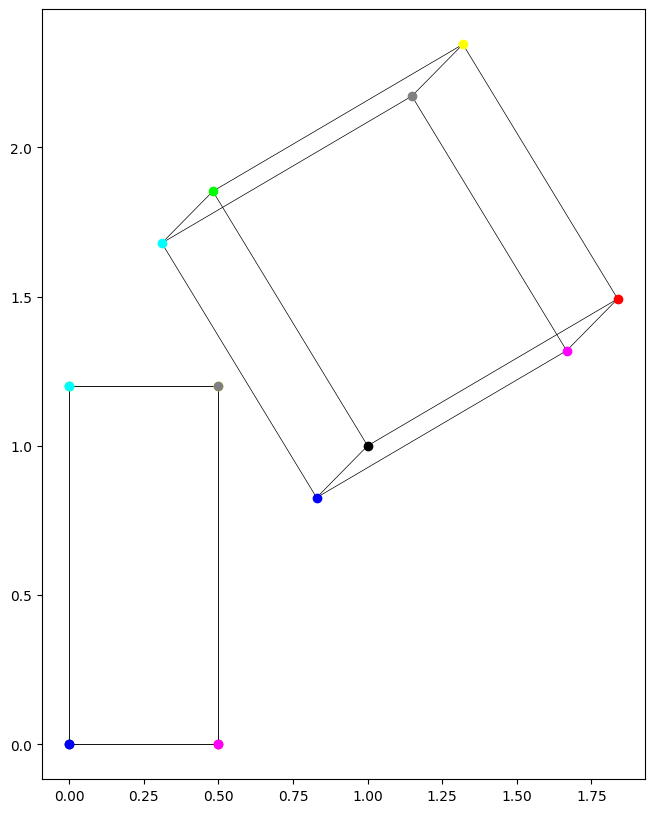

In [664]:
# Place cubes in the scene 

# --- First Cube 

# Scale the first cube by 50% in x-, 120% in y- and 50% in z direction
# Place it such that the object origin is at the world origin 

# Compute object-to-world transform for first cube
scale_transform = np.array([
    [0.5, 0, 0, 0],
    [0, 1.2, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0,   1]
])

wC1o = scale_transform 

# --- Second Cube 

# Rotate the cube by 30deg around the z axis
# Rotate the cube by 10deg around the x axis
# Rotate the cube by 10deg around the y axis
# Move the cube coordinate system origin to world cooridnates (1, 1, 0)
theta_z = math.radians(30)
rotation_transform_z = np.array([
    [math.cos(theta_z), -math.sin(theta_z), 0, 0],
    [math.sin(theta_z), math.cos(theta_z), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])


theta_x = math.radians(10)
rotation_transform_x = np.array([
    [1, 0, 0, 0],
    [0, math.cos(theta_x), -math.sin(theta_x), 0],
    [0, math.sin(theta_x), math.cos(theta_x), 0],
    [0, 0, 0, 1]
])


theta_y = math.radians(10)
rotation_transform_y = np.array([
    [math.cos(theta_y), 0, -math.sin(theta_y), 0],
    [0, 1, 0, 0],
    [math.sin(theta_y), 0, math.cos(theta_y), 0],
    [0, 0, 0, 1]
])

translation_transform_110 = np.array([
    [1, 0, 0, 1],
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])


# Compute object-to-world transform for second cube
wC2o = matmul(translation_transform_110, rotation_transform_y, rotation_transform_x, rotation_transform_z)

# --- Draw scene from top looking orthographically at the x-y plane
C1_projected_vertices = [
     np.matmul(wC1o, Xo) for Xo in cube_vertices
]

C2_projected_vertices = [
     np.matmul(wC2o, Xo) for Xo in cube_vertices
]

f = plt.figure(figsize=(10, 10))
draw_cube(C1_projected_vertices)
draw_cube(C2_projected_vertices)


In [665]:
C1_projected_vertices

[array([0., 0., 0., 1.]),
 array([0.5, 0. , 0. , 1. ]),
 array([0.5, 0. , 0.5, 1. ]),
 array([0. , 0. , 0.5, 1. ]),
 array([0. , 1.2, 0. , 1. ]),
 array([0.5, 1.2, 0. , 1. ]),
 array([0.5, 1.2, 0.5, 1. ]),
 array([0. , 1.2, 0.5, 1. ])]

## Q2 Define calibration matrix K 

In [666]:
# Image width and height
w = 640
h = 480

# Focal length
f = 5 

# Compute s, such that -1 to 1 from world coordinates fits into the height of the image
# The scale factor transforms from metric to pixel space and the offsets move to the sensor origin
s = h/2

# Compute ox and oy
# Note: the top left pixel CENTER should be at 0,0 in sensor coordinates
ox = (w-1)/2
oy = (h-1)/2

# Set up 3x3 matrix K 
# Should probably be f*s (slide 13 lec4 part A)
K = data([
    [s*f, 0, ox],
    [0, s*f, oy],
    [0, 0, 1]
])

In [667]:
print(K)

[[1200.     0.   319.5]
 [   0.  1200.   239.5]
 [   0.     0.     1. ]]


## Q3 Define first camera

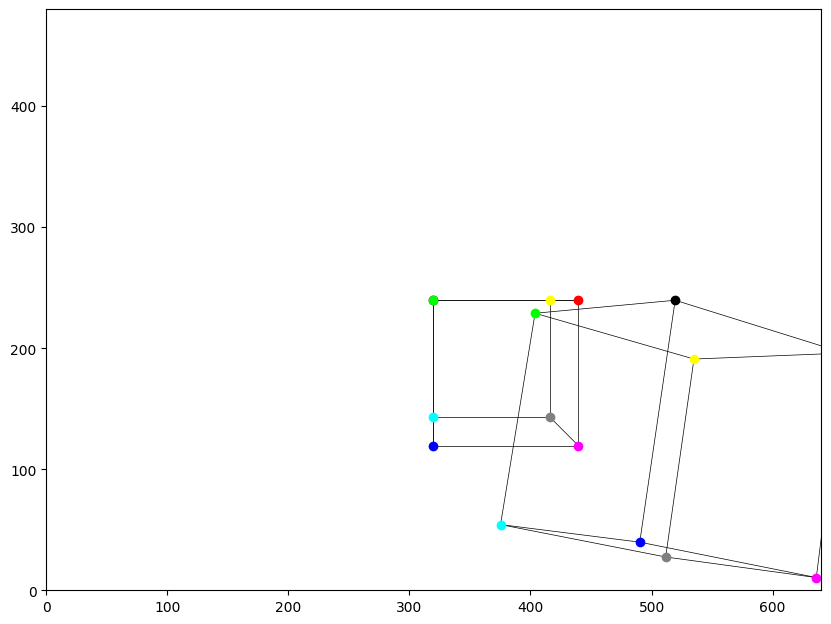

In [668]:
# Set the origin of the camera to be at (0, -5, 0)
translation_transform_o = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 5],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Rotate the camera such that its z-axis points in the direction of the world y-axis 
rotation_transform_x = np.array([
    [1, 0, 0, 0],
    [0, 0, -1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

# Compute world to camera1 matrix 
k1Hw = matmul(rotation_transform_x, translation_transform_o)

# Project everything to the camera and plot it
C1_camera = [
     pi(np.matmul(k1Hw, Xo)) for Xo in C1_projected_vertices
]

# Set to homogenious coordinate and put in image
C1_image = [
     pi(matmul(K, Xo)) for Xo in C1_camera
]
# Drop homogenious coordinate
C1_image = np.array(C1_image)[:,:2]


C2_camera = [
     pi(np.matmul(k1Hw, Xo)) for Xo in C2_projected_vertices
]

# Set to homogenious coordinate and put in image
C2_image = [
     pi(matmul(K, Xo)) for Xo in C2_camera
]
# Drop homogenious coordinate
C2_image = np.array(C2_image)[:,:2]


f = plt.figure(figsize=(10, 10))
plt.xlim([0, w])
plt.ylim([0, h])
draw_cube(C1_image)
draw_cube(C2_image)

In [669]:
C1_image

array([[319.5       , 239.5       ],
       [439.5       , 239.5       ],
       [439.5       , 119.5       ],
       [319.5       , 119.5       ],
       [319.5       , 239.5       ],
       [416.27419355, 239.5       ],
       [416.27419355, 142.72580645],
       [319.5       , 142.72580645]])

In [670]:
# For name of variables to coincide with next excercise
C1_projected_vertices = C1_image
C2_projected_vertices = C2_image
print(C1_projected_vertices)

[[319.5        239.5       ]
 [439.5        239.5       ]
 [439.5        119.5       ]
 [319.5        119.5       ]
 [319.5        239.5       ]
 [416.27419355 239.5       ]
 [416.27419355 142.72580645]
 [319.5        142.72580645]]


## Q4 Unproject a point to world coordinates from different depth values

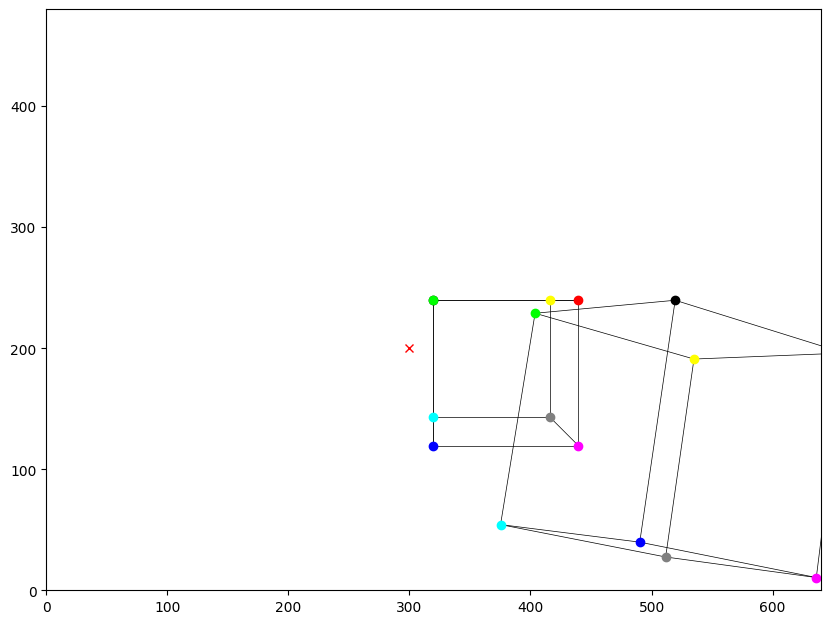

In [671]:
# Data 
xs = 300 # Sensor x coordinate 
ys = 200 # Sensor y coordinate
depths = [0.1, 6, 8, 10, 12, 14, 16, 18, 20] # Depths to unproject
unprojected_points = [] # List of unprojected points to be filled in

# Plot point in camera 
f = plt.figure(figsize=(10,10))
plt.xlim([0, w])
plt.ylim([0, h])
draw_cube(C1_projected_vertices)
draw_cube(C2_projected_vertices)
plt.plot(xs, ys, 'rx')

# Unproject points
inv_K = np.linalg.inv(K)
inv_k1Hw = np.linalg.inv(k1Hw)

point = [xs, ys]
for depth in depths:
    # Add homogenious dimension + depth information
    inv_pi_point = depth*np.append(point,1)
    inv_k_point = np.matmul(inv_K, np.transpose(inv_pi_point))
    # Add homogenious third dimension + inverse n1Hw
    unprojected_points.append(np.matmul(np.linalg.inv(k1Hw),np.transpose(np.append(inv_k_point,1))))

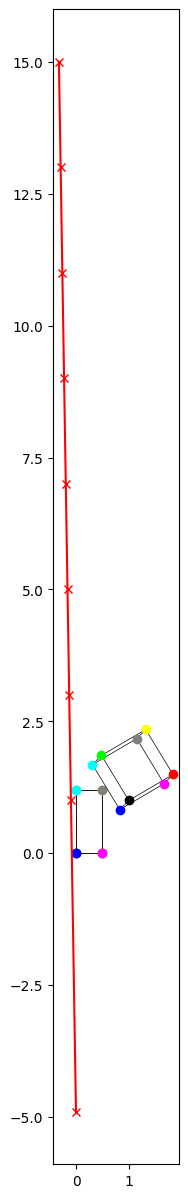

In [672]:
# Draw scene from top
C1_projected_vertices = [
     np.matmul(wC1o, Xo) for Xo in cube_vertices
]

C2_projected_vertices = [
     np.matmul(wC2o, Xo) for Xo in cube_vertices
]

f = plt.figure(figsize=(5, 15))
draw_cube(C1_projected_vertices)
draw_cube(C2_projected_vertices)

# Draw unprojected points
plt.plot([p[0] for p in unprojected_points], [p[1] for p in unprojected_points], 'rx-')    

In [673]:
# Reproject points to check if they match the original sensor coordinates
projected_points = [
    pi(matmul(K,pi(matmul(k1Hw, Xo)))) for Xo in unprojected_points
]
for p in projected_points:
    print('projected_point:', p)

projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]
projected_point: [299.9999901  200.00000079]


## Q5 Do the projection with a 3x4 matrix P instead

In [674]:
C1_projected_vertices

[array([0., 0., 0., 1.]),
 array([0.5, 0. , 0. , 1. ]),
 array([0.5, 0. , 0.5, 1. ]),
 array([0. , 0. , 0.5, 1. ]),
 array([0. , 1.2, 0. , 1. ]),
 array([0.5, 1.2, 0. , 1. ]),
 array([0.5, 1.2, 0.5, 1. ]),
 array([0. , 1.2, 0.5, 1. ])]

P: [[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  1.  0.  5.]]


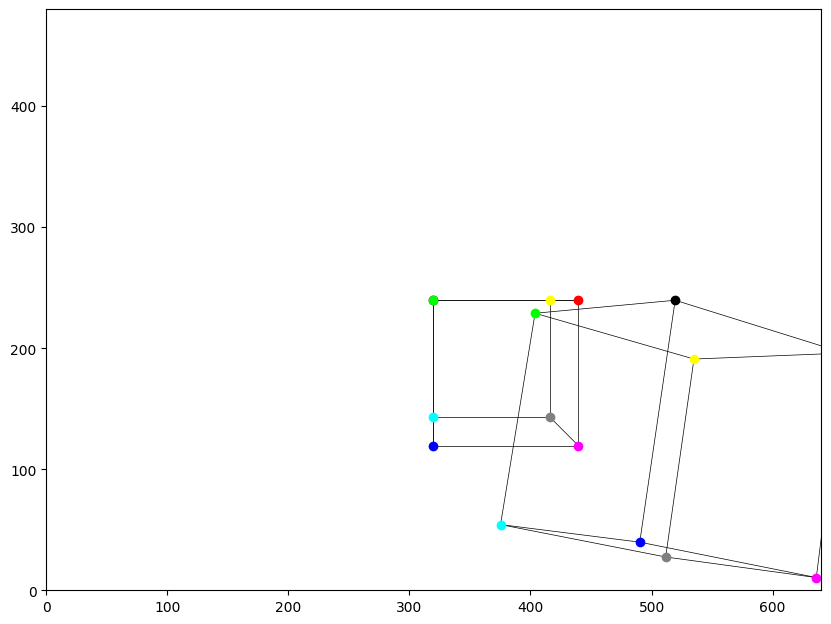

In [687]:
# Use matrix P 
P = np.zeros((3, 4), dtype=np.float32)

r = [
     [1, 0, 0],
     [0, 0, -1],
     [0, 1, 0],
]

t = np.array([0,0,5])
P[0:3,0:3] = r
P[:,3] = t

# Print matrix
np.set_printoptions(suppress=True)
print('P:', P)

# Render scene to camera 1 using matrix P 
C1_projected_vertices_P = [
     pi(matmul(K, P, Xo)) for Xo in C1_projected_vertices
]

C2_projected_vertices_P = [
     pi(matmul(K, P, Xo))for Xo in C2_projected_vertices
]

f = plt.figure(figsize=(10, 10))
plt.xlim([0, w])
plt.ylim([0, h])
draw_cube(C1_projected_vertices_P)
draw_cube(C2_projected_vertices_P)

In [688]:
C1_projected_vertices_P

[array([319.5, 239.5]),
 array([439.5, 239.5]),
 array([439.5, 119.5]),
 array([319.5, 119.5]),
 array([319.5, 239.5]),
 array([416.27419355, 239.5       ]),
 array([416.27419355, 142.72580645]),
 array([319.5       , 142.72580645])]

## Q6 Define camera 2 from given cooridnate system axes

translation_matrix [[ 1.  0.  0. -4.]
 [ 0.  1.  0.  5.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  0.  1.]]
rotation_matrix [[ 0.8660254   0.5         0.          0.        ]
 [-0.10395585  0.18005681 -0.9781476   0.        ]
 [-0.4890738   0.8471007   0.20791167  0.        ]
 [ 0.          0.          0.          1.        ]]


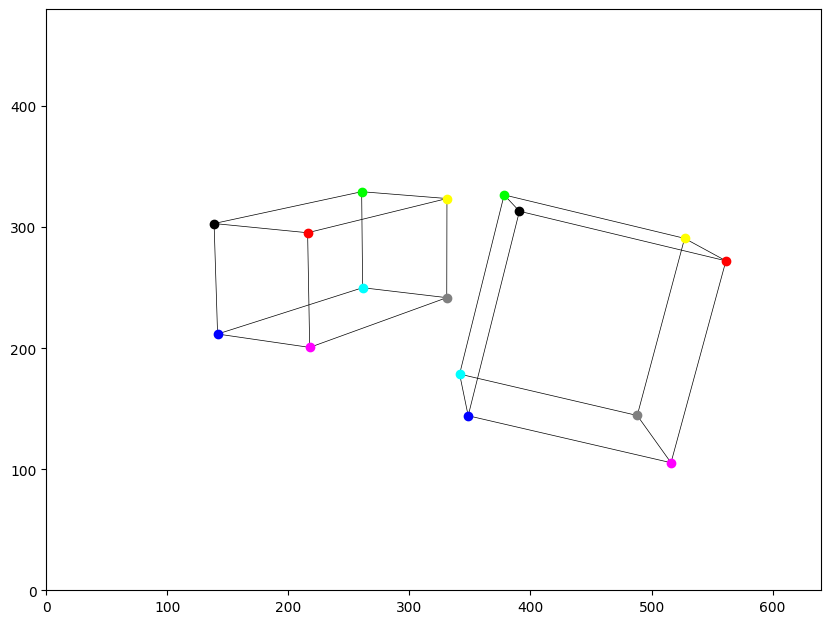

In [689]:
# Camera 2 parameters: 
# Origin in world coordinates: [4, -5, -1]
# Direction of x-axis in world coordinates: [0.8660254, 0.5, 0]
# Direction of y-axis in world coordinates: [-0.10395585, 0.18005681, -0.9781476]
# Direction of z-axis in world coordinates: [-0.4890738, 0.8471007, 0.20791167]


# Given camera parameters
origin = np.array([-4, 5, 1])
x_axis = np.array([0.8660254, 0.5, 0])
y_axis = np.array([-0.10395585, 0.18005681, -0.9781476])
z_axis = np.array([-0.4890738, 0.8471007, 0.20791167])

# Translation matrix
translation_matrix = np.eye(4)
translation_matrix[:3, 3] = origin
print("translation_matrix", translation_matrix)

# Rotation matrix
rotation_matrix = np.row_stack((x_axis, y_axis, z_axis, [0, 0, 0]))
rotation_matrix = np.column_stack((rotation_matrix, [0, 0, 0, 1]))
print("rotation_matrix", rotation_matrix)
# Combine translation and rotation matrices
k2Hw = np.matmul(rotation_matrix, translation_matrix)

# Project everything to the camera and plot it
C1_camera = [
     pi(np.matmul(k2Hw, Xo)) for Xo in C1_projected_vertices
]

# Set to homogenious coordinate and put in image
C1_image = [
     pi(matmul(K, Xo)) for Xo in C1_camera
]
# Drop homogenious coordinate
C1_image = np.array(C1_image)[:,:2]


C2_camera = [
     pi(np.matmul(k2Hw, Xo)) for Xo in C2_projected_vertices
]

# Set to homogenious coordinate and put in image
C2_image = [
     pi(matmul(K, Xo)) for Xo in C2_camera
]
# Drop homogenious coordinate
C2_image = np.array(C2_image)[:,:2]


f = plt.figure(figsize=(10, 10))
plt.xlim([0, w])
plt.ylim([0, h])
draw_cube(C1_image)
draw_cube(C2_image)

## Reproject points from Q5 to camera2 

[-1501.78414682   -52.3789288 ]
[229.76627935 294.29635458]
[375.57228865 323.48830812]
[474.76138175 343.34704653]
[546.60870031 357.73166343]
[601.05008649 368.6314228 ]
[643.72735429 377.17587735]
[678.08181446 384.05401502]
[706.33179828 389.70996994]


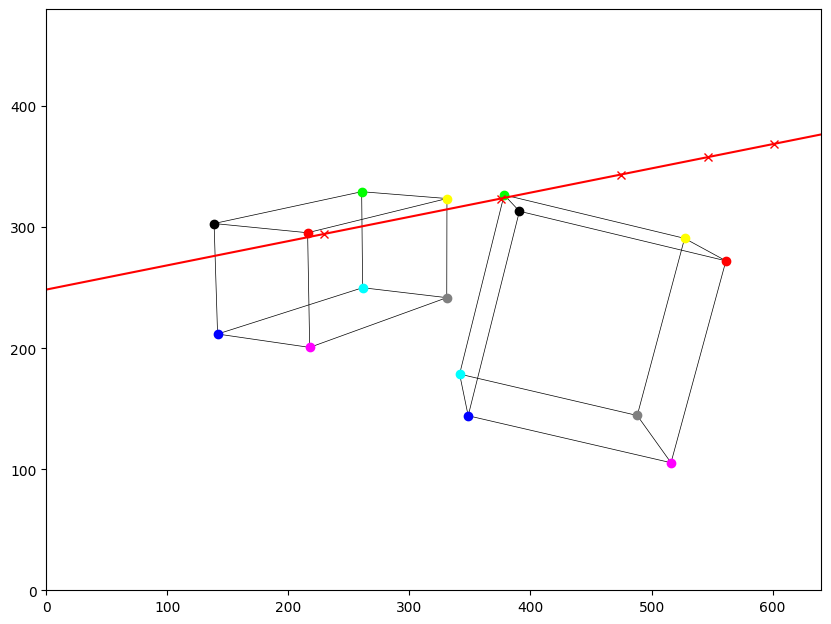

In [692]:
C1_projected_vertices = C1_image
C2_projected_vertices = C2_image

# Reproject points
proj_camera = [
     pi(np.matmul(k2Hw, Xo)) for Xo in unprojected_points
]

# Set to homogenious coordinate and put in image
proj_image = [
     pi(matmul(K, Xo)) for Xo in proj_camera
]
# Drop homogenious coordinate
projected_points = np.array(proj_image)[:,:2]

# Render scene 
f = plt.figure(figsize=(10, 10))
plt.xlim([0, w])
plt.ylim([0, h])
draw_cube(C1_projected_vertices)
draw_cube(C2_projected_vertices)

# Draw unprojected points
for p in projected_points: 
    print(p)

plt.plot([p[0] for p in projected_points], [p[1] for p in projected_points], 'rx-')        